In [1]:
from numpy.linalg import pinv, norm, solve, lstsq
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
S, R = make_regression(n_samples=10000, n_features=100, n_informative=10, noise=50.0, random_state=1)
S, S_test, R, R_test = train_test_split(S, R)

In [36]:
w = pinv(S) @ R
R_pred = S @ w
print(r2_score(R, R_pred))
print(mean_squared_error(R, R_pred))

# w = lstsq(S, R, rcond=-1)[0]
# R_pred = S@w
# print(r2_score(R, R_pred), )
# print(mean_squared_error(R, R_pred))

R_pred = S_test @ w
print(r2_score(R_test, R_pred))
print(mean_squared_error(R_test, R_pred))

0.9263210443119383
2414.686240864292
0.9250071096383969
2481.2119075369037


In [37]:
S.std(axis=0)

array([1.00522158, 1.00536609, 0.9975363 , 1.00272783, 0.9912519 ,
       1.00095262, 0.98789597, 1.00529568, 1.00208246, 1.01569154,
       0.99744395, 0.98479945, 1.00071142, 0.98997815, 1.02155193,
       0.98927261, 0.99153115, 0.99202906, 0.99326204, 1.00038745,
       1.00793625, 0.99173603, 0.99960275, 1.00244718, 1.00513417,
       0.99147939, 0.99930994, 0.99367271, 0.99986876, 1.00529728,
       0.98789449, 1.00733288, 1.00623199, 1.00725258, 0.98253735,
       0.99310818, 1.00761472, 0.98752261, 0.99118056, 1.00368956,
       1.0095158 , 0.9918521 , 0.98690154, 1.00653165, 0.99593677,
       1.01138845, 1.00269078, 0.98075409, 0.99036995, 1.00033022,
       0.99389808, 1.00961991, 1.00731933, 0.99019171, 0.98776331,
       0.99521461, 1.00123167, 1.00729848, 0.98148644, 1.00298148,
       1.00164112, 1.00453215, 1.0069608 , 1.00380186, 0.99641863,
       0.98504759, 1.00461773, 1.00456926, 1.00172848, 1.01250053,
       0.98829842, 0.99533719, 1.00465159, 1.00329848, 0.99447

**Задача**: Проверить, что для решения задачи регрессии выбор данных с помощью максимизации статистичекого объема лучше выбора случайной подвыборки того же размера. 

**Дизайн эксперимента**:  
*В цикле*:  
Из $S$ вытаскивается 4 (количество действий) вектора $\phi(s, a)$.
Далее рассматривается два способа выбора одного из этих векторов для занесения в свою историю $H$ (exploration):  
1. Агент выбирает одно из них согласно $argmax ||H^+ \phi(s,a)||_2$
2. Агент выбирает одно из них случайно
3. (---) Агент выбирает одно из них $\varepsilon$-жадно согласно на данной момент выученной Q-функции

C некоторой частотой обучаем регрессию на собранных разными способами H и сравниваем результаты. Хочется, чтобы у первого способа качество было лучше

In [8]:
from copy import deepcopy

class A:
    def __init__(self):
        self.var = 0
    def update_var(self, value):
        self.var = value
    def evaluate_var(self):
        return self.var
    def choose_var(self, values):
        results = []
        for value in values:
            fantom = deepcopy(self)
            fantom.update_var(value)
            results += [(fantom, fantom.evaluate_var())]
        self = deepcopy(self)
        
agent = A()
agent.choose_var([1, 3, 6])

In [9]:
agent.var

0

In [39]:
class Agent:
    def __init__(self, method='random'):
        self.H = None #states
        self.R = [] # rewards for self.H - used for fit
        self.w = None # Q-function weights
        self.method = method
        
#       todo: add fit_flag
        
    def choose_phi(self, Phi, R, method=None, update_H=True):
        if method is None:
            method = self.method
        if self.H is None:
            method = 'random'
            
        if method == 'random':
            ind = np.random.randint(Phi.shape[0], size=1)
        elif method == 'stat_volume':
#             H_pinv = pinv(self.H)
#             print([norm(H_pinv.T@phi) for phi in Phi])
#             ind = np.argmax([norm(H_pinv.T@phi) for phi in Phi])
            ind = np.argmax([np.linalg.det(np.vstack([self.H, phi]).T @ np.vstack([self.H, phi])) for phi in Phi])
            
        phi = Phi[ind]
        r = R[ind]
            
        if update_H:
            self.update_H(phi)
            self.R += [r]
        return phi, r
    
    def update_H(self, phi):
        if self.H is None:
            self.H = phi
        else:
            self.H = np.vstack([self.H, phi])
    def fit(self):
        self.w = pinv(self.H) @ self.R
    def predict(self, S):
        return S @ self.w
    def evaluate(self, S=S_test, R=R_test):
        R_pred = self.predict(S)
        r2 = r2_score(R, R_pred)
        mse = mean_squared_error(R, R_pred)
#         print('r2_score', r2)
#         print('mse', mse)
        return r2, mse
        

In [40]:
from tqdm import tqdm_notebook

scores = pd.DataFrame()


for n_iter in tqdm_notebook(range(10)):
    smart_agent = Agent('stat_volume')
    random_agent = Agent('random')

    agents = {'random': random_agent,
                'smart': smart_agent,
             }

    for i in range(500):
        ind = np.random.randint(S.shape[0], size=4)
        for agent_name, agent in agents.items():
    #         print(i, agent_name)
            phi, r = agent.choose_phi(S[ind], R[ind])
            if (i >= 10 and i%10 == 0) or i in [1, 2, 5]:
                agent.fit()
                r2, mse = agent.evaluate(S_test, R_test)
                scores.at[i, agent_name+f'_{n_iter}'] = r2

# fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
# for agent_name in agents:
#     ax[0].plot(scores[agent_name], label=agent_name)
# ax[0].set_title('R2 score')
# ax[0].legend()

# ax[1].plot(scores['random'] / scores['smart'], label = 'random / smart')    
# ax[1].plot(scores*0 + 1)   
# # ax[0].title('R2 score')
# ax[1].legend()
# plt.show()

In [41]:
scores

,random_0,smart_0,random_1,smart_1,random_2,smart_2,random_3,smart_3,random_4,smart_4,random_5,smart_5,random_6,smart_6,random_7,smart_7,random_8,smart_8,random_9,smart_9
1,0.002291,0.009408,0.018817,0.005541,0.037904,0.001006,0.014045,0.009545,0.028494,0.012995,0.024409,0.034921,0.034645,0.017449,0.009333,0.007108,0.028227,0.048769,0.023486,0.002116
2,0.009191,0.008645,0.018376,0.007961,0.051195,0.013660,0.085503,0.019072,0.028287,0.016397,0.027127,0.061423,0.044834,0.013983,0.014753,0.013219,0.028247,0.048845,0.023670,0.000906
5,0.089664,0.031362,0.058646,0.066959,0.059665,0.041079,0.088141,0.047655,0.064531,0.046999,0.069827,0.085183,0.054931,0.028897,0.042062,0.039287,0.057201,0.065922,0.028757,0.061130
10,0.139739,0.042821,0.142332,0.130019,0.081374,0.095017,0.120110,0.072051,0.108322,0.100497,0.104748,0.118541,0.097109,0.065313,0.095678,0.077017,0.070989,0.103661,0.059930,0.117240
20,0.235641,0.128887,0.230343,0.182025,0.142982,0.136663,0.148655,0.177134,0.133661,0.237250,0.173950,0.163076,0.133541,0.200370,0.156209,0.153080,0.132555,0.125297,0.166145,0.284829
30,0.313275,0.222829,0.323600,0.331744,0.225321,0.289823,0.203418,0.219695,0.277847,0.343251,0.246789,0.253315,0.138882,0.290715,0.176093,0.187792,0.211241,0.199991,0.294339,0.378684
40,0.359917,0.262366,0.444490,0.362311,0.320062,0.346623,0.293554,0.293184,0.296060,0.431302,0.257191,0.275947,0.284376,0.353668,0.247029,0.292531,0.269248,0.271569,0.400448,0.417374
50,0.420417,0.296037,0.461421,0.468890,0.337146,0.511857,0.373039,0.396788,0.363056,0.459067,0.349402,0.348276,0.443142,0.437941,0.331390,0.313992,0.397548,0.454603,0.466446,0.457075
60,0.458142,0.328680,0.536170,0.474977,0.431285,0.578669,0.492805,0.468187,0.427236,0.452456,0.426268,0.512403,0.433876,0.456629,0.451331,0.404474,0.468714,0.462743,0.537599,0.449204
70,0.513443,0.284271,0.613269,0.437142,0.461297,0.502621,0.489592,0.522388,0.433227,0.466866,0.425194,0.562397,0.504860,0.469840,0.582379,0.445455,0.440426,0.466392,0.548733,0.604868


In [42]:
for agent in agents:
    agent_cols = [x for x in scores.columns if agent in x]
    scores[agent + '_mean'] = scores[agent_cols].mean(axis=1)
    scores[agent + '_std'] = scores[agent_cols].std(axis=1)

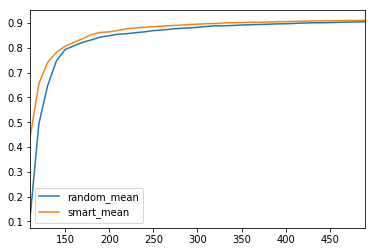

In [48]:
scores[13:][[agent + '_mean' for agent in agents]].plot()

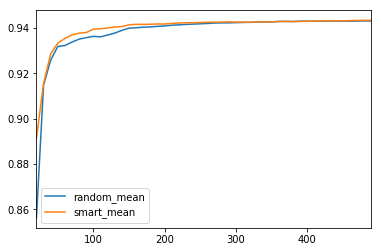

In [14]:
scores[4:][[agent + '_mean' for agent in agents]].plot()

In [29]:
scores['random_std'], 

(1      0.099729
 2      0.200056
 5      0.236309
 10     1.339545
 20     0.036501
 30     0.016294
 40     0.009052
 50     0.007849
 60     0.005297
 70     0.003003
 80     0.002330
 90     0.002320
 100    0.001858
 110    0.002299
 120    0.002136
 130    0.002275
 140    0.002285
 150    0.001910
 160    0.001917
 170    0.001813
 180    0.001718
 190    0.001709
 200    0.001776
 210    0.001364
 220    0.000916
 230    0.000845
 240    0.000717
 250    0.000633
 260    0.000668
 270    0.000461
 280    0.000397
 290    0.000312
 300    0.000436
 310    0.000338
 320    0.000450
 330    0.000414
 340    0.000407
 350    0.000417
 360    0.000425
 370    0.000538
 380    0.000676
 390    0.000786
 400    0.000660
 410    0.000587
 420    0.000655
 430    0.000555
 440    0.000540
 450    0.000590
 460    0.000561
 470    0.000559
 480    0.000466
 490    0.000411
 Name: random_std, dtype: float64,)

In [30]:
smart_agent.w

array([array([90.15913283]), array([3.57297708]), array([53.04283033]),
       array([20.92518792]), array([53.27023537]), array([84.28314734]),
       array([35.1106614]), array([52.71459153]), array([95.62275292]),
       array([72.71596591])], dtype=object)

In [98]:
scores

,smart,random
0,0.073787,0.009010
1,0.103978,0.263832
2,0.675810,0.341641
3,0.548269,0.404120
4,0.457308,0.401996
5,0.323538,0.473877
6,-0.688576,0.573388
7,-12.580280,0.637192
8,-26.154818,0.755548
9,-89.147737,0.737222
